In [2]:
#data tools
from src import prepare_europe_data, prepare_empty_frame, plot_covid_data, get_daily_cases, tukey_outliers, crosscorr, MAPE
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
import itertools

#linear algebra/ math
import numpy as np 
from math import sqrt

#plots
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pandas.plotting import lag_plot
plt.style.use('seaborn')

#metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
#statistical tools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import ccf
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy import stats

#models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.optimize import curve_fit
from statsmodels.tsa.arima_model import ARIMA

In [3]:
data_path = '../../data/raw/time_series_covid19_confirmed_global.csv'
data_raw = pd.read_csv(data_path)
data_prepared_poland = prepare_europe_data(data=data_raw, start_date='4/1/20', end_date='5/20/20', country='Poland')
df = data_prepared_poland

In [4]:
plot_covid_data(data=data_prepared_poland, country='Poland')

In [5]:
df, daily_growth_series = get_daily_cases(df)

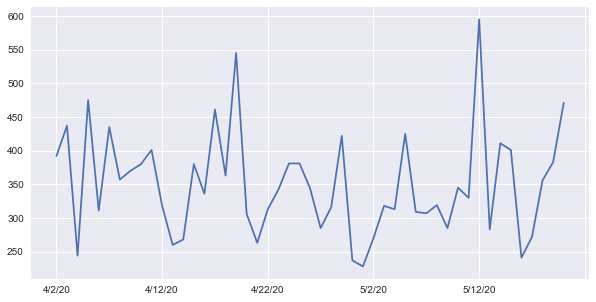

In [6]:
plt.figure(figsize=(10,5))
daily_growth_series.plot()

In [7]:
from fbprophet import Prophet

In [8]:
df_daily = pd.DataFrame(daily_growth_series)
df_daily['ds'] = df_daily.index
df_daily = df_daily.rename(columns = {'DailyGrowthCases':'y'})
df_daily = df_daily.reset_index()
del df_daily['index']
df_daily = df_daily[['ds', 'y']]
df_daily.ds = pd.to_datetime(df_daily.ds)

In [9]:
m = Prophet()
m.fit(df_daily)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
df_daily.tail()

,ds,y
44,2020-05-16,241
45,2020-05-17,272
46,2020-05-18,356
47,2020-05-19,383
48,2020-05-20,471


In [11]:
future = m.make_future_dataframe(periods=7)
future.tail()

,ds
51,2020-05-23
52,2020-05-24
53,2020-05-25
54,2020-05-26
55,2020-05-27


In [12]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
51,2020-05-23,298.639725,205.715399,389.080828
52,2020-05-24,360.346782,271.107673,449.152640
53,2020-05-25,295.212716,205.716835,390.837146
54,2020-05-26,370.060946,279.180804,455.701736
55,2020-05-27,348.635406,256.088192,442.780958


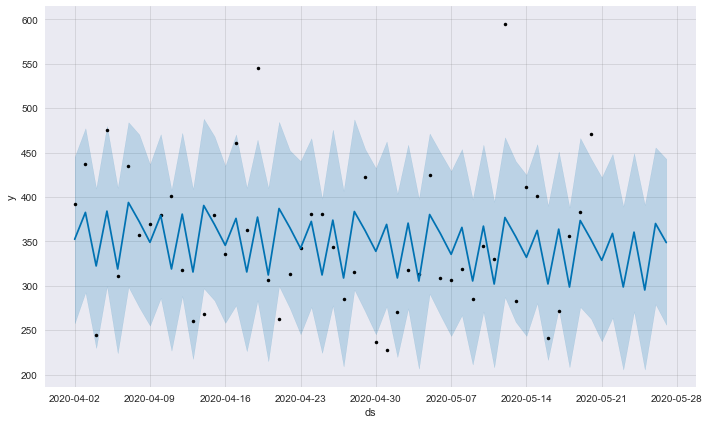

In [13]:
fig1 = m.plot(forecast)

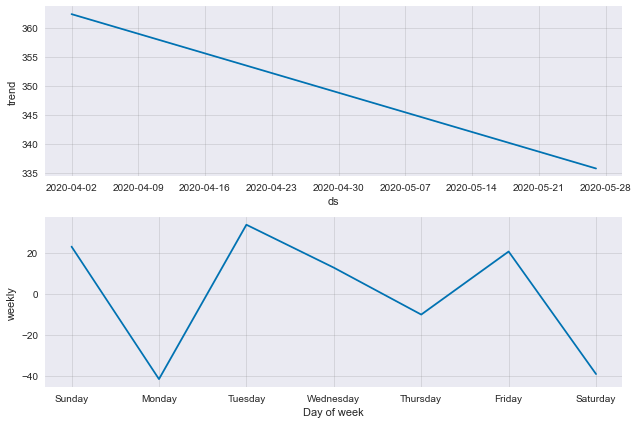

In [14]:
fig2 = m.plot_components(forecast)

In [15]:
next_week = forecast[-7:]['yhat'].sum()
next_week_daily = forecast[-7:]['yhat']

In [16]:
poland_gt = prepare_europe_data(data=data_raw, start_date='5/20/20', end_date='5/27/20', country='Poland')

In [17]:
df_poland_gt, daily_growth_series_gt = get_daily_cases(poland_gt)

In [18]:
daily_growth_series_gt

5/21/20    404
5/22/20    476
5/23/20    312
5/24/20    395
5/25/20    305
5/26/20    443
5/27/20    399
Name: DailyGrowthCases, dtype: object

In [19]:
gt_total = poland_gt['5/27/20'].values[0]
gt_total

22473

In [20]:
predicted_total = poland_gt['5/20/20'].values[0] + next_week
predicted_total

22099.448459175124

In [21]:
mse_score = mean_squared_error(next_week_daily, daily_growth_series_gt)
mae_score = mean_absolute_error(next_week_daily, daily_growth_series_gt)
rmse_score = np.sqrt(mean_squared_error(next_week_daily, daily_growth_series_gt))
mape_score = MAPE(daily_growth_series_gt,next_week_daily)

In [24]:
next_week_daily

49    328.635353
50    358.917531
51    298.639725
52    360.346782
53    295.212716
54    370.060946
55    348.635406
Name: yhat, dtype: float64

In [25]:
daily_growth_series_gt

5/21/20    404
5/22/20    476
5/23/20    312
5/24/20    395
5/25/20    305
5/26/20    443
5/27/20    399
Name: DailyGrowthCases, dtype: object

In [26]:
print('\nMean absolute percentage error: %f'%mape_score)
print('\nMean squared error: %f'%mse_score)
print('\nMean absolute error: %f'%mae_score)
print('\nRoot mean squared error: %f'%rmse_score)


Mean absolute percentage error: 12.657618

Mean squared error: 4102.852280

Mean absolute error: 53.364506

Root mean squared error: 64.053511


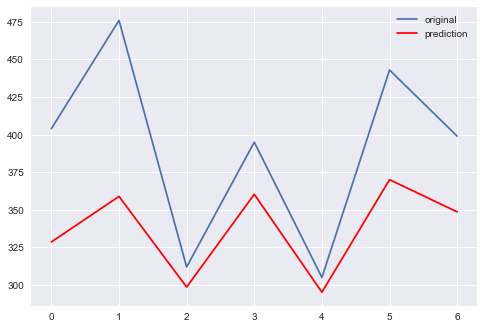

In [30]:
plt.plot(daily_growth_series_gt.values, label='original')
plt.plot(next_week_daily.values, color='red', label='prediction')

plt.legend()
plt.show()

In [23]:
gt_total - predicted_total

373.5515408248757

Predicted for 5/27/20 - 22099

Official for 5/27/20 - 22473

Error - (373) ConfirmedCases